### Warning!
Due to issue caused by the keras tokenizer, the models that were trained during the competation and evaluated cannot be loaded properly. This is link to the issue https://github.com/keras-team/keras/issues/4875 . In order to provide pretrained models just for loading I will train the models again expecting similar f1 score with just minor change.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figsize=(9, 7)):
    matrix = confusion_matrix(y_true, y_pred)

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 size=int((figsize[0] / 10) * 38),
                 color="white" if matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
train = pd.read_csv("split/train.csv")
dev = pd.read_csv("split/dev.csv")
test = pd.read_csv("split/test.csv")

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
TEXT = "aliased_snippet"
RESULT = "is_parent"
COMPANY1= "company1"
COMPANY2 = "company2"

In [9]:
onto_test = pd.read_csv("./processed/test.csv")

In [10]:
corpus = train[TEXT].append(dev[TEXT]).append(test[TEXT]).append(onto_test[TEXT])
corpus.shape

(97385,)

In [11]:
num_words = 39000
max_len = 40

In [14]:
import pickle
from os.path import exists
tokenizer_name = "tokenizer.pickle"
tokenizer = None
if not exists(tokenizer_name):
    
    tokenizer  = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(corpus)

    with open(tokenizer_name, "wb") as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

In [15]:
def tokenize(data):
    tokenized = tokenizer.texts_to_sequences(data[TEXT])
    tokenized = pad_sequences(tokenized,maxlen=max_len)
    return tokenized

In [16]:
train_tokenized = tokenize(train)

In [17]:
train_tokenized.shape, train_tokenized[0]

((55568, 40),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,  137,   23,
           2, 1139,   19,    3,  104,   89,  981,  137,   23,    2, 1139,
          19,    3,  104,   89,  981,    2,    5], dtype=int32))

In [18]:
dev_tokenized = tokenize(dev)

In [19]:
dev_tokenized.shape

(15876, 40)

In [95]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, Dropout, Bidirectional, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [139]:
model = Sequential([
    Embedding(num_words,128, input_length=train_tokenized.shape[1]),
    Bidirectional(LSTM(200, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.4),
    Dense(16, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

In [140]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 40, 128)           4992000   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 40, 400)           526400    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 400)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               51328     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                2064      
__________

In [141]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [142]:
early_stoping = EarlyStopping(patience=2)

In [143]:
checkpoint = ModelCheckpoint(filepath="./models/bi_lstm.h5", save_best_only=True)

In [144]:
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 94s 2ms/step - loss: 0.4941 - acc: 0.7574 - val_loss: 0.3646 - val_acc: 0.8418
Epoch 2/10
55568/55568 [==============================] - 87s 2ms/step - loss: 0.2947 - acc: 0.8793 - val_loss: 0.3131 - val_acc: 0.8674
Epoch 3/10
55568/55568 [==============================] - 84s 2ms/step - loss: 0.1735 - acc: 0.9350 - val_loss: 0.3546 - val_acc: 0.8570
Epoch 4/10
55568/55568 [==============================] - 81s 1ms/step - loss: 0.1093 - acc: 0.9617 - val_loss: 0.3957 - val_acc: 0.8685


The result above is result of many small parameter changes and tuning in the network and training with smaller batch gived better results due to smaller gradient I suppose.

In [27]:
test_tokenized = tokenize(test)
test_tokenized.shape

(7939, 40)

In [43]:
from keras.models import load_model

In [30]:
from sklearn.metrics import f1_score

In [158]:
def score_model(model):
    predictions = model.predict(test_tokenized)    
    predictions_binary = np.round(predictions)
    plot_confusion_matrix(test[RESULT], predictions_binary,classes=[0,1], normalize=False) 
    print("F1 score of test is {}".format(f1_score(test[RESULT], predictions_binary)))    

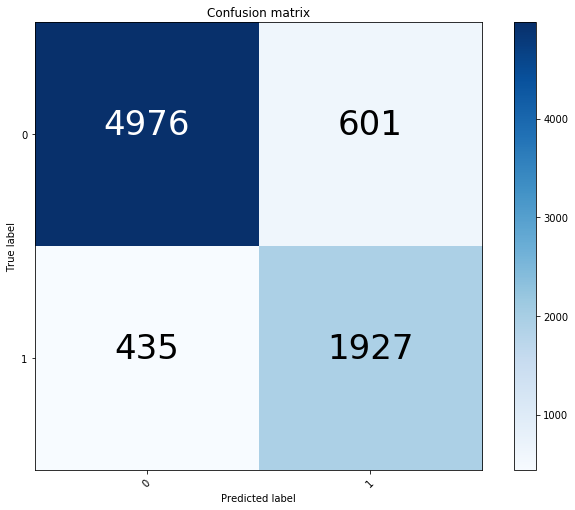

F1 score of test is 0.7881390593047035


In [159]:
score_model(model)

In [148]:
model.save("models/bi_lstm_100_200_788f1.h5")

In [74]:
onto_test.shape

(18002, 5)

In [75]:
onto_test[:5]

,company1,company2,is_parent,snippet,aliased_snippet
0,Ford_Motor_Company,Holden,NaN,95s to top the sheets ahead of Kiwi Fabian Cou...,95s to top the sheets ahead of kiwi fabian cou...
2,Apple_Inc.,HBO,NaN,\nGamers who want to access HBO Now on the Xbo...,\ngamers who want to access company2 now on ...
3,Apple_Inc.,HBO,NaN,\nHBO first launched its standalone subscripti...,\n company2 first launched its standalone sub...
5,Google,Verizon_Communications,NaN,\nGoogle's business immediately took a hit : p...,\n company1 's business immediately took a hit...
6,Twitter,Beats_Electronics,NaN,"His endorsement list ain't bad either, includ...","his endorsement list ain't bad either, includ..."


In [163]:
%mkdir onto-test

In [151]:
def predict_onto(model, save_name):
    onto_test = pd.read_csv("./processed/test.csv")
    onto_test_tokenized = tokenize(onto_test)    
    pred = model.predict(onto_test_tokenized)
    onto_test[RESULT] = pred
    onto_test.to_csv("./onto-test/"+save_name, index=False)

In [152]:
def predict_onto_diff_pairs(model, save_name):
    onto_test = pd.read_csv("./processed/test.csv")
    

This is the best model for lstm so far that's why I will save the test result for eval

In [63]:
from keras.models import load_model
model = load_model("models/bi_lstm_100_200_788f1.h5")

In [153]:
predict_onto(model, "bi_lstm_pretrained_788f1.csv")

In [154]:
def show_onto(save_name):
    return pd.read_csv("./onto-test/"+save_name)

In [155]:
pred = show_onto("bi_lstm.csv")

In [156]:
pred.shape

(18002, 5)

In [157]:
pred[:5]

,company1,company2,is_parent,snippet,aliased_snippet
0,Ford_Motor_Company,Holden,1.089333e-04,95s to top the sheets ahead of Kiwi Fabian Cou...,95s to top the sheets ahead of kiwi fabian cou...
1,Apple_Inc.,HBO,5.136681e-06,\nGamers who want to access HBO Now on the Xbo...,\ngamers who want to access company2 now on ...
2,Apple_Inc.,HBO,3.838687e-03,\nHBO first launched its standalone subscripti...,\n company2 first launched its standalone sub...
3,Google,Verizon_Communications,3.283885e-06,\nGoogle's business immediately took a hit : p...,\n company1 's business immediately took a hit...
4,Twitter,Beats_Electronics,3.509106e-07,"His endorsement list ain't bad either, includ...","his endorsement list ain't bad either, includ..."


### Whats next?
The code above was just to clarify everything works as aspected, now lets expolore if adding some CNN filters will improve the score. My hipotesis is by adding convolutions the model will be able to filter only the most useful features and will improve the score above

In [19]:
from keras.layers import Convolution1D,MaxPooling1D, GlobalAveragePooling1D,Flatten, AveragePooling1D
from keras.regularizers import l1,l2

In [50]:
model = Sequential([
    Embedding(num_words,128, input_length=train_tokenized.shape[1]),
    Convolution1D(8, kernel_size=2, padding="same", activation="relu"),
    MaxPooling1D(pool_size=3),
    Convolution1D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling1D(),
    Dropout(0.3),
    Bidirectional(LSTM(200, return_sequences=True)),
    GlobalAveragePooling1D(),
    Dropout(0.4),
    Dense(100, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 128)           4992000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 40, 8)             2056      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 13, 8)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 13, 16)            400       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 6, 16)             0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 16)             0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 6, 400)            347200    
__________

In [52]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [53]:
checkpoint = ModelCheckpoint(filepath="./models/conv_bi_lstm.h5", save_best_only=True)

In [54]:
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=32, epochs=10, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 37s 668us/step - loss: 0.5221 - acc: 0.7409 - val_loss: 0.4587 - val_acc: 0.7883
Epoch 2/10
55568/55568 [==============================] - 35s 633us/step - loss: 0.3829 - acc: 0.8300 - val_loss: 0.4208 - val_acc: 0.8044
Epoch 3/10
55568/55568 [==============================] - 35s 632us/step - loss: 0.3031 - acc: 0.8729 - val_loss: 0.4402 - val_acc: 0.8045
Epoch 4/10
55568/55568 [==============================] - 35s 633us/step - loss: 0.2478 - acc: 0.9004 - val_loss: 0.4656 - val_acc: 0.8027


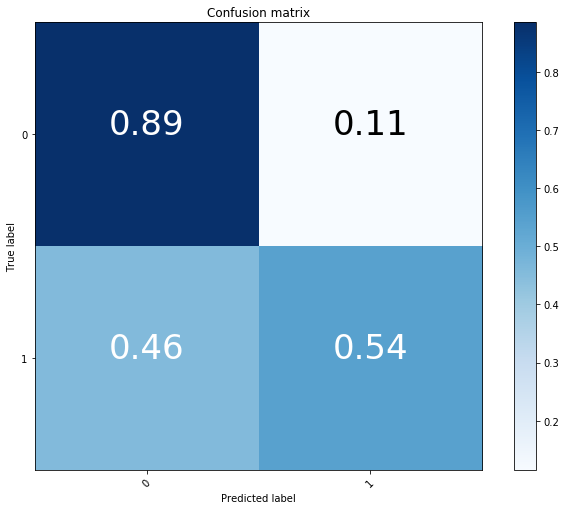

F1 score of test is 0.5986934204386374


In [41]:
score_model(model)

I have used similar architecture in other classification problems and it gived small improvemene. However in this case the filters actually made the network to give more True Positives but also give less True Negatives.
Here is short list of things personally I wanted to try with cnn but didn't: 
Kim et al., EMNLP 2014, 'Convolutional Neural Networks for Sentence Classification ' (https://github.com/yoonkim/CNN_sentence).
https://github.com/UKPLab/deeplearning4nlp-tutorial/blob/master/2017-07_Seminar/Session%203%20-%20Relation%20CNN/Relation_CNN.pdf
https://arxiv.org/pdf/1504.06580.pdf

### Now what?
Don't think I have gived up. Lets see if pretrained word embeddings can give better score.

In [58]:
def load_vectors(path, dim):
    with open(path) as lines:
        w2v = {line.split()[0]: np.array( list( map(float,line.split()[1:]) ))
           for line in lines}
        embedding_matrix = np.zeros((len(w2v) + 1, dim))
        for i,word in enumerate(w2v):
            embedding_vector = w2v[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
        return w2v, embedding_matrix
    

In [59]:
# You can download them from https://nlp.stanford.edu/projects/glove/
w2v, embedding_matrix = load_vectors("/home/radoslav/git/neuroner/NeuroNER-master/data/word_vectors/glove.6B.100d.txt", 100)

In [67]:
model = Sequential([
    Embedding(len(w2v) + 1,100,weights=[embedding_matrix],input_length=max_len,trainable=False),
    Bidirectional(LSTM(200, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

In [68]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 100)           40000100  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 40, 400)           481600    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 400)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               51328     
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total para

In [71]:
checkpoint = ModelCheckpoint(filepath="./models/glove.6B.100_bi_lstm.h5", save_best_only=True)

In [72]:
model.fit(train_tokenized, train[RESULT],validation_data=(dev_tokenized, dev[RESULT]), batch_size=64, epochs=10, callbacks=[early_stoping, checkpoint])

Train on 55568 samples, validate on 15876 samples
Epoch 1/10
55568/55568 [==============================] - 57s 1ms/step - loss: 0.5487 - acc: 0.7250 - val_loss: 0.4899 - val_acc: 0.7627
Epoch 2/10
55568/55568 [==============================] - 56s 1ms/step - loss: 0.4735 - acc: 0.7751 - val_loss: 0.4428 - val_acc: 0.7933
Epoch 3/10
55568/55568 [==============================] - 55s 998us/step - loss: 0.4220 - acc: 0.8048 - val_loss: 0.4154 - val_acc: 0.8058
Epoch 4/10
55568/55568 [==============================] - 55s 995us/step - loss: 0.3807 - acc: 0.8279 - val_loss: 0.4071 - val_acc: 0.8116
Epoch 5/10
55568/55568 [==============================] - 55s 995us/step - loss: 0.3410 - acc: 0.8489 - val_loss: 0.3967 - val_acc: 0.8262
Epoch 6/10
55568/55568 [==============================] - 55s 984us/step - loss: 0.2985 - acc: 0.8725 - val_loss: 0.3987 - val_acc: 0.8313
Epoch 7/10
55568/55568 [==============================] - 55s 992us/step - loss: 0.2511 - acc: 0.8948 - val_loss: 0.3814

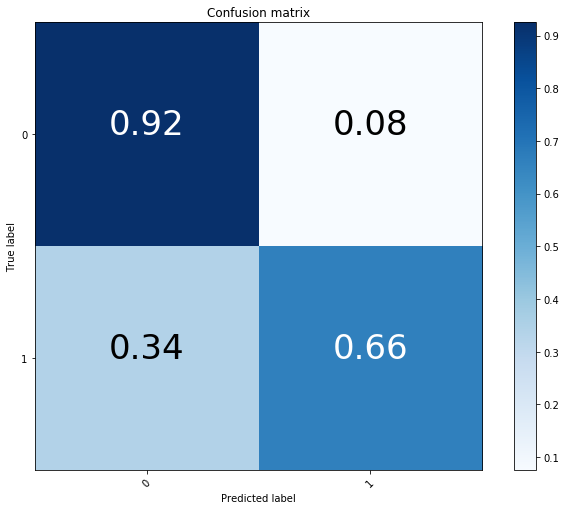

F1 score of test is 0.7193184434722542


In [73]:
score_model(model)

It seems that we have a miss with those glove pretrained but lets try word2vec

In [20]:
from gensim.models import KeyedVectors

In [21]:
# You can find some vectors here https://github.com/3Top/word2vec-api
word2vec = KeyedVectors.load_word2vec_format("/media/radoslav/6906F83679A14133/word2vec/GoogleNews-vectors-negative300.bin", binary=True)

In [71]:
word2vec.wv["car"][:5]

array([ 0.13085938,  0.00842285,  0.03344727, -0.05883789,  0.04003906],
      dtype=float32)

In [22]:
model = Sequential([
    word2vec.get_keras_embedding(),
    Bidirectional(LSTM(200, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

ResourceExhaustedError: OOM when allocating tensor with shape[3000000,300]
	 [[Node: embedding_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=7438567, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_1/random_uniform/shape)]]

Caused by op 'embedding_1/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-d6f287452260>", line 8, in <module>
    Dense(1, activation="sigmoid")
  File "/usr/local/lib/python3.5/dist-packages/keras/models.py", line 408, in __init__
    self.add(layer)
  File "/usr/local/lib/python3.5/dist-packages/keras/models.py", line 464, in add
    layer(x)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/embeddings.py", line 101, in build
    dtype=self.dtype)
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 397, in add_weight
    weight = K.variable(initializer(shape),
  File "/usr/local/lib/python3.5/dist-packages/keras/initializers.py", line 107, in __call__
    dtype=dtype, seed=self.seed)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 3637, in random_uniform
    dtype=dtype, seed=seed)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/random_ops.py", line 240, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_random_ops.py", line 473, in _random_uniform
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3000000,300]
	 [[Node: embedding_1/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=7438567, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_1/random_uniform/shape)]]


Sadly :(, it seems my GPU does not have enough memory, someone should check if it gives better results

###  Ahh, I'd like to share something at the end!
There many other things to try in order to solve the problem and I will share my ideas that I didn't test:
* TF-IDF vectorization of the sentence with features similar to ones in the Classical Machine Learning notebook but with feed-forward network
* LSTM with POS tags of each word in addition to the sequence
* Having better preprocessing of the text snippets

#### Okey you use the test set (10%) but why don't you do cross-validation for param tuning
The short answer is gpu and time since I am currently training on nvidia gtx 970. Anyway I found cool articles about that.
* https://stackoverflow.com/questions/25889637/how-to-use-k-fold-cross-validation-in-a-neural-network
* http://www.cs.cmu.edu/~guestrin/Class/10701-S05/slides/NNet-CrossValidation-2-2-2005.pdf